In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

BASE_DIR = r"D:\illegal-logging-detector"
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
AUGMENTED_DIR = os.path.join(BASE_DIR, "data", "augmented")
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

os.makedirs(os.path.join(MODELS_DIR, "baseline"), exist_ok=True)
os.makedirs(os.path.join(MODELS_DIR, "final"), exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

class LoggingDataset(Dataset):
    def __init__(self, data_dir, use_augmented=False):
        self.files = []
        self.labels = []
        
        if use_augmented:
            # Use augmented data for training
            for fname in os.listdir(os.path.join(data_dir, "logging")):
                self.files.append(os.path.join(data_dir, "logging", fname))
                self.labels.append(1)
            for fname in os.listdir(os.path.join(data_dir, "non_logging")):
                self.files.append(os.path.join(data_dir, "non_logging", fname))
                self.labels.append(0)
        else:
            # Use processed data for val/test
            for fname in os.listdir(os.path.join(data_dir, "logging")):
                self.files.append(os.path.join(data_dir, "logging", fname))
                self.labels.append(1)
            for fname in os.listdir(os.path.join(data_dir, "non_logging")):
                self.files.append(os.path.join(data_dir, "non_logging", fname))
                self.labels.append(0)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        mel = np.load(self.files[idx])
        # Add channel dimension (1, 128, 216)
        mel = torch.FloatTensor(mel).unsqueeze(0)
        label = torch.LongTensor([self.labels[idx]])[0]
        return mel, label

# Create datasets
train_dataset = LoggingDataset(AUGMENTED_DIR, use_augmented=True)
val_dataset   = LoggingDataset(os.path.join(PROCESSED_DIR, "val"))
test_dataset  = LoggingDataset(os.path.join(PROCESSED_DIR, "test"))

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Val samples:   {len(val_dataset)}")
print(f"✅ Test samples:  {len(test_dataset)}")
print(f"✅ Train batches: {len(train_loader)}")

✅ Using device: cuda
✅ Train samples: 735
✅ Val samples:   31
✅ Test samples:  32
✅ Train batches: 23


In [2]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 27, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = BaselineCNN().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model created")
print(f"✅ Total parameters: {total_params:,}")

# Test with dummy input
dummy = torch.randn(1, 1, 128, 216).to(device)
output = model(dummy)
print(f"✅ Input shape:  {dummy.shape}")
print(f"✅ Output shape: {output.shape}")
print(f"✅ Model is working correctly")

✅ Model created
✅ Total parameters: 14,265,730
✅ Input shape:  torch.Size([1, 1, 128, 216])
✅ Output shape: torch.Size([1, 2])
✅ Model is working correctly


In [4]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    return total_loss/len(loader), 100.*correct/total

def val_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    return total_loss/len(loader), 100.*correct/total

# Training loop
EPOCHS = 30
best_val_acc = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("🚀 Starting training...")
print("-" * 60)

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc     = val_epoch(model, val_loader, criterion)
    
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODELS_DIR, "baseline", "best_model.pth"))
        print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.1f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.1f}% ⭐ saved")
    else:
        print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.1f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.1f}%")

print("-" * 60)
print(f"\n✅ Training complete!")
print(f"✅ Best validation accuracy: {best_val_acc:.1f}%")

🚀 Starting training...
------------------------------------------------------------
Epoch 01/30 | Train Loss: 2.7218 | Train Acc: 54.0% | Val Loss: 0.6930 | Val Acc: 58.1% ⭐ saved
Epoch 02/30 | Train Loss: 1.0273 | Train Acc: 56.3% | Val Loss: 0.6891 | Val Acc: 58.1%
Epoch 03/30 | Train Loss: 0.7825 | Train Acc: 55.6% | Val Loss: 0.6920 | Val Acc: 45.2%
Epoch 04/30 | Train Loss: 0.7150 | Train Acc: 54.3% | Val Loss: 0.6950 | Val Acc: 41.9%
Epoch 05/30 | Train Loss: 0.6830 | Train Acc: 57.7% | Val Loss: 0.6885 | Val Acc: 58.1%
Epoch 06/30 | Train Loss: 0.6827 | Train Acc: 59.9% | Val Loss: 0.6810 | Val Acc: 58.1%
Epoch 07/30 | Train Loss: 0.6710 | Train Acc: 58.4% | Val Loss: 0.6772 | Val Acc: 58.1%
Epoch 08/30 | Train Loss: 0.6407 | Train Acc: 61.4% | Val Loss: 0.6934 | Val Acc: 58.1%
Epoch 09/30 | Train Loss: 0.6573 | Train Acc: 61.2% | Val Loss: 0.7126 | Val Acc: 64.5% ⭐ saved
Epoch 10/30 | Train Loss: 0.6264 | Train Acc: 61.2% | Val Loss: 0.7548 | Val Acc: 64.5%
Epoch 11/30 | Train 

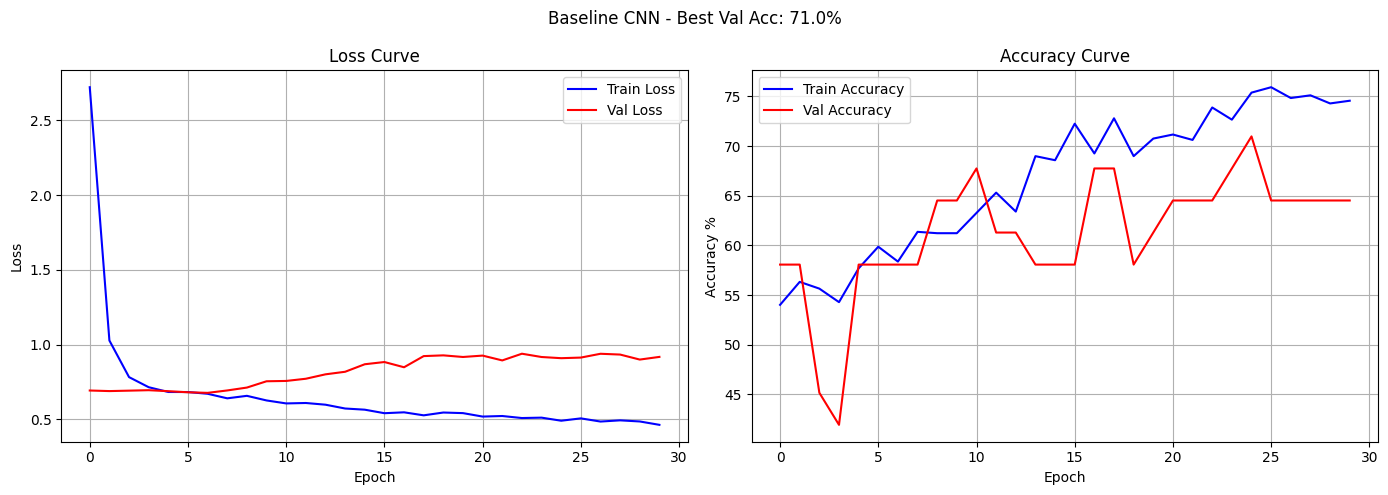

✅ Saved to results folder


In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax1.plot(train_losses, label="Train Loss", color="blue")
ax1.plot(val_losses, label="Val Loss", color="red")
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy curve
ax2.plot(train_accs, label="Train Accuracy", color="blue")
ax2.plot(val_accs, label="Val Accuracy", color="red")
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy %")
ax2.legend()
ax2.grid(True)

plt.suptitle(f"Baseline CNN - Best Val Acc: {best_val_acc:.1f}%")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "baseline_training_curves.png"))
plt.show()

print("✅ Saved to results folder")

In [6]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Block 1 - smaller than before
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            
            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            
            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 27, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False
    
    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize improved model
model2 = ImprovedCNN().to(device)
total_params = sum(p.numel() for p in model2.parameters())
print(f"✅ Improved model created")
print(f"✅ Total parameters: {total_params:,}")

# Optimizer with weight decay
criterion2  = nn.CrossEntropyLoss()
optimizer2  = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)
scheduler2  = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, patience=3, factor=0.5)
early_stop  = EarlyStopping(patience=7)

# Training loop
EPOCHS = 50
best_val_acc2 = 0
train_losses2, val_losses2 = [], []
train_accs2, val_accs2 = [], []

print("\n🚀 Starting improved training...")
print("-" * 60)

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model2, train_loader, optimizer2, criterion2)
    val_loss, val_acc     = val_epoch(model2, val_loader, criterion2)
    
    scheduler2.step(val_loss)
    early_stop.step(val_loss)
    
    train_losses2.append(train_loss)
    val_losses2.append(val_loss)
    train_accs2.append(train_acc)
    val_accs2.append(val_acc)
    
    if val_acc > best_val_acc2:
        best_val_acc2 = val_acc
        torch.save(model2.state_dict(), os.path.join(MODELS_DIR, "baseline", "best_model_v2.pth"))
        print(f"Epoch {epoch+1:02d} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | Loss: {val_loss:.4f} ⭐ saved")
    else:
        print(f"Epoch {epoch+1:02d} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | Loss: {val_loss:.4f}")
    
    if early_stop.should_stop:
        print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
        break

print("-" * 60)
print(f"\n✅ Training complete!")
print(f"✅ Best validation accuracy: {best_val_acc2:.1f}%")
print(f"✅ Baseline was: {best_val_acc:.1f}%")
print(f"✅ Improvement: +{best_val_acc2 - best_val_acc:.1f}%")

✅ Improved model created
✅ Total parameters: 3,562,850

🚀 Starting improved training...
------------------------------------------------------------
Epoch 01 | Train: 53.6% | Val: 58.1% | Loss: 0.6799 ⭐ saved
Epoch 02 | Train: 57.8% | Val: 58.1% | Loss: 0.6640
Epoch 03 | Train: 58.0% | Val: 61.3% | Loss: 0.6658 ⭐ saved
Epoch 04 | Train: 62.4% | Val: 61.3% | Loss: 0.6848
Epoch 05 | Train: 60.1% | Val: 64.5% | Loss: 0.7028 ⭐ saved
Epoch 06 | Train: 61.0% | Val: 54.8% | Loss: 0.7274
Epoch 07 | Train: 63.3% | Val: 54.8% | Loss: 0.7238
Epoch 08 | Train: 64.1% | Val: 61.3% | Loss: 0.7165
Epoch 09 | Train: 65.2% | Val: 61.3% | Loss: 0.7485

⏹️ Early stopping triggered at epoch 9
------------------------------------------------------------

✅ Training complete!
✅ Best validation accuracy: 64.5%
✅ Baseline was: 71.0%
✅ Improvement: +-6.5%


In [7]:
import torchvision.models as models

class ResNetLogging(nn.Module):
    def __init__(self):
        super(ResNetLogging, self).__init__()
        
        # Load pretrained ResNet18
        self.resnet = models.resnet18(weights="IMAGENET1K_V1")
        
        # Modify first layer to accept 1 channel (grayscale spectrogram)
        # instead of 3 channels (RGB image)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Replace final layer with our 2 class classifier
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        return self.resnet(x)

# Freeze all layers except last few
model3 = ResNetLogging().to(device)

# Freeze everything first
for param in model3.resnet.parameters():
    param.requires_grad = False

# Unfreeze last 2 blocks + classifier
for param in model3.resnet.layer3.parameters():
    param.requires_grad = True
for param in model3.resnet.layer4.parameters():
    param.requires_grad = True
for param in model3.resnet.fc.parameters():
    param.requires_grad = True
for param in model3.resnet.conv1.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in model3.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model3.parameters())
print(f"✅ ResNet18 transfer learning model created")
print(f"✅ Total parameters:     {total:,}")
print(f"✅ Trainable parameters: {trainable:,}")
print(f"✅ Frozen parameters:    {total-trainable:,}")

# Test forward pass
dummy = torch.randn(1, 1, 128, 216).to(device)
out   = model3(dummy)
print(f"✅ Output shape: {out.shape}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Kunal/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:09<00:00, 5.19MB/s]


✅ ResNet18 transfer learning model created
✅ Total parameters:     11,171,266
✅ Trainable parameters: 10,497,602
✅ Frozen parameters:    673,664
✅ Output shape: torch.Size([1, 2])


In [8]:
# Fresh early stopping and optimizer for ResNet
early_stop3 = EarlyStopping(patience=10)
criterion3  = nn.CrossEntropyLoss()
optimizer3  = optim.Adam(model3.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler3  = optim.lr_scheduler.ReduceLROnPlateau(optimizer3, patience=4, factor=0.5)

EPOCHS = 50
best_val_acc3 = 0
train_losses3, val_losses3 = [], []
train_accs3, val_accs3 = [], []

print("🚀 Starting ResNet18 transfer learning...")
print("-" * 60)

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model3, train_loader, optimizer3, criterion3)
    val_loss, val_acc     = val_epoch(model3, val_loader, criterion3)
    
    scheduler3.step(val_loss)
    early_stop3.step(val_loss)
    
    train_losses3.append(train_loss)
    val_losses3.append(val_loss)
    train_accs3.append(train_acc)
    val_accs3.append(val_acc)
    
    if val_acc > best_val_acc3:
        best_val_acc3 = val_acc
        torch.save(model3.state_dict(), os.path.join(MODELS_DIR, "final", "resnet18_best.pth"))
        print(f"Epoch {epoch+1:02d} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | Loss: {val_loss:.4f} ⭐ saved")
    else:
        print(f"Epoch {epoch+1:02d} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | Loss: {val_loss:.4f}")
    
    if early_stop3.should_stop:
        print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
        break

print("-" * 60)
print(f"\n✅ Training complete!")
print(f"✅ ResNet18 best val accuracy: {best_val_acc3:.1f}%")
print(f"✅ Baseline CNN was:           {best_val_acc:.1f}%")
print(f"✅ Improvement:                +{best_val_acc3 - best_val_acc:.1f}%")

🚀 Starting ResNet18 transfer learning...
------------------------------------------------------------
Epoch 01 | Train: 75.5% | Val: 54.8% | Loss: 0.6982 ⭐ saved
Epoch 02 | Train: 96.7% | Val: 96.8% | Loss: 0.3598 ⭐ saved
Epoch 03 | Train: 99.9% | Val: 83.9% | Loss: 0.4211
Epoch 04 | Train: 99.6% | Val: 80.6% | Loss: 0.5694
Epoch 05 | Train: 100.0% | Val: 80.6% | Loss: 0.6258
Epoch 06 | Train: 100.0% | Val: 80.6% | Loss: 0.4976
Epoch 07 | Train: 100.0% | Val: 80.6% | Loss: 0.5154
Epoch 08 | Train: 100.0% | Val: 80.6% | Loss: 0.5612
Epoch 09 | Train: 100.0% | Val: 77.4% | Loss: 0.5824
Epoch 10 | Train: 100.0% | Val: 83.9% | Loss: 0.5051
Epoch 11 | Train: 99.9% | Val: 80.6% | Loss: 0.5053
Epoch 12 | Train: 100.0% | Val: 80.6% | Loss: 0.5670

⏹️ Early stopping triggered at epoch 12
------------------------------------------------------------

✅ Training complete!
✅ ResNet18 best val accuracy: 96.8%
✅ Baseline CNN was:           71.0%
✅ Improvement:                +25.8%


📊 Test Set Results:
----------------------------------------
✅ Accuracy:  81.2%
✅ Precision: 83.3%
✅ Recall:    71.4%
✅ F1 Score:  76.9%
----------------------------------------

📋 Full Classification Report:
              precision    recall  f1-score   support

 Non Logging       0.80      0.89      0.84        18
     Logging       0.83      0.71      0.77        14

    accuracy                           0.81        32
   macro avg       0.82      0.80      0.81        32
weighted avg       0.81      0.81      0.81        32



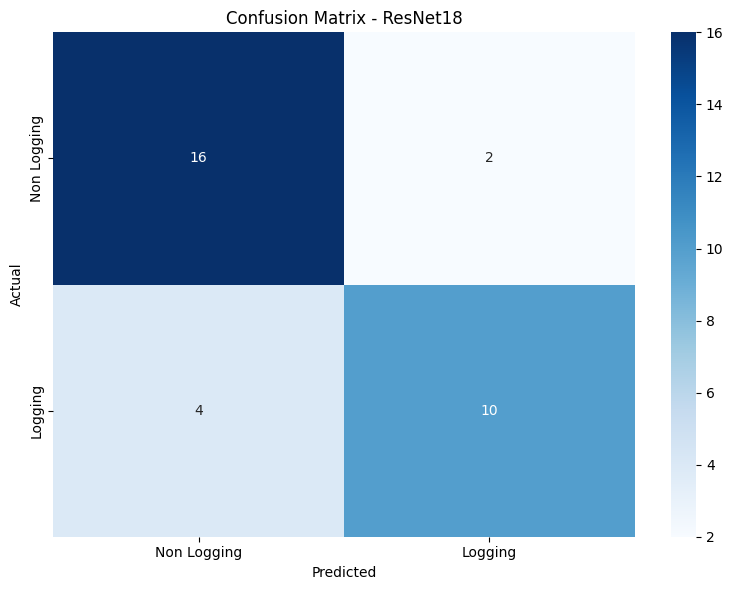

✅ Saved confusion matrix to results folder


In [9]:
# Load best model
model3.load_state_dict(torch.load(os.path.join(MODELS_DIR, "final", "resnet18_best.pth")))
model3.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(all_labels, all_preds) * 100
prec = precision_score(all_labels, all_preds) * 100
rec  = recall_score(all_labels, all_preds) * 100
f1   = f1_score(all_labels, all_preds) * 100

print("📊 Test Set Results:")
print("-" * 40)
print(f"✅ Accuracy:  {acc:.1f}%")
print(f"✅ Precision: {prec:.1f}%")
print(f"✅ Recall:    {rec:.1f}%")
print(f"✅ F1 Score:  {f1:.1f}%")
print("-" * 40)
print("\n📋 Full Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non Logging", "Logging"]))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non Logging", "Logging"],
            yticklabels=["Non Logging", "Logging"])
plt.title("Confusion Matrix - ResNet18")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"))
plt.show()
print("✅ Saved confusion matrix to results folder")

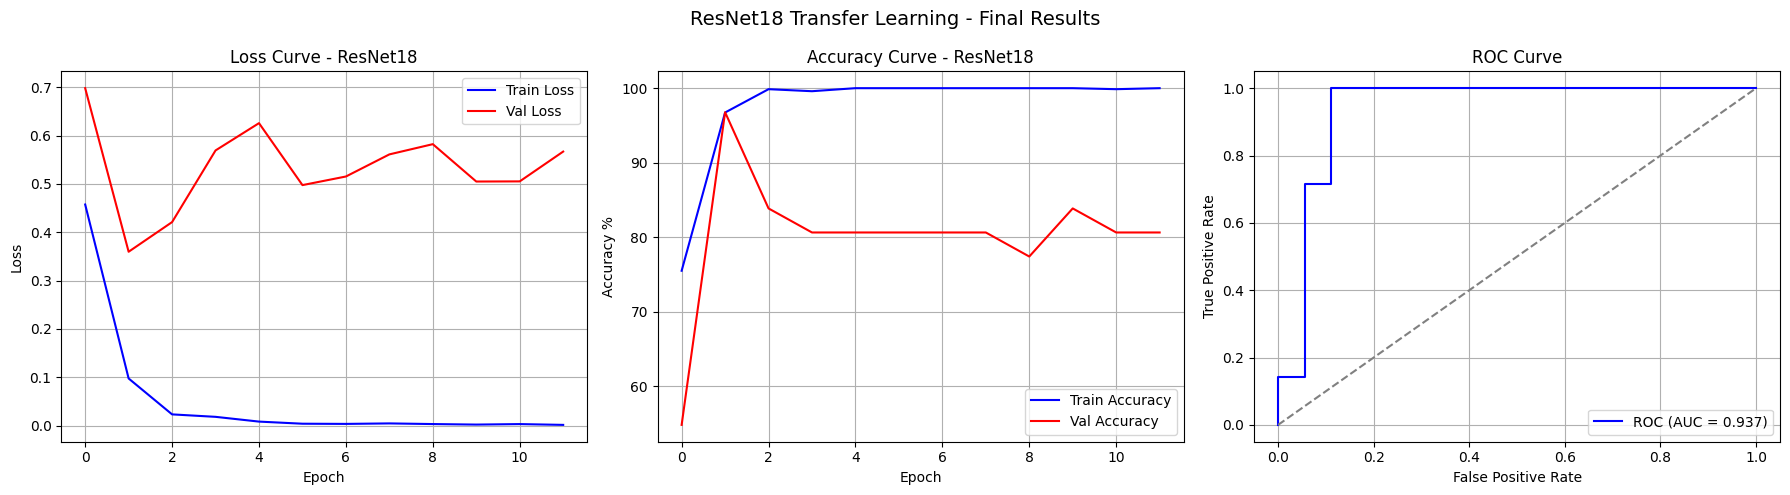

✅ Saved to results folder

📊 Final Summary:
   Test Accuracy:  81.2%
   Test Precision: 83.3%
   Test Recall:    71.4%
   Test F1:        76.9%
   ROC AUC:        0.937


In [10]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training curves
axes[0].plot(train_losses3, label="Train Loss", color="blue")
axes[0].plot(val_losses3, label="Val Loss", color="red")
axes[0].set_title("Loss Curve - ResNet18")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_accs3, label="Train Accuracy", color="blue")
axes[1].plot(val_accs3, label="Val Accuracy", color="red")
axes[1].set_title("Accuracy Curve - ResNet18")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy %")
axes[1].legend()
axes[1].grid(True)

# ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
axes[2].plot(fpr, tpr, color="blue", label=f"ROC (AUC = {roc_auc:.3f})")
axes[2].plot([0,1], [0,1], color="gray", linestyle="--")
axes[2].set_title("ROC Curve")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].legend()
axes[2].grid(True)

plt.suptitle("ResNet18 Transfer Learning - Final Results", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "final_results.png"))
plt.show()

print(f"✅ Saved to results folder")
print(f"\n📊 Final Summary:")
print(f"   Test Accuracy:  {acc:.1f}%")
print(f"   Test Precision: {prec:.1f}%")
print(f"   Test Recall:    {rec:.1f}%")
print(f"   Test F1:        {f1:.1f}%")
print(f"   ROC AUC:        {roc_auc:.3f}")